3. Классификация
================

**Цель работы**: Изучить основные понятия, связанные с классификацией, научиться применять библиотеку scikit-learn, применить полученные знания для решения практических задач.

Подготовка библиотек
--------------------

In [1]:
import numpy as np
import scipy.io as sio
import scipy.optimize as so
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
rc('font', family='Verdana')

Классификация
-------------

Задача классификации — это задача восстановления связи между объектами (описываемыми некоторым набором признаков) и конечным набором классов (описываемых номерами — метками).

Эта задача широко распространена. Вот лишь несколько примеров:

- выявление спама,
- распознавание голосовых команд,
- биометрическая идентификация,
- медицинская диагностика,
- выявление эмоциональной окраски текста,
- разпознавание текста на изображениях и т. д.

Если классов два, то говорят о бинарной классификации. Если больше, то о многоклассовой классификации. Многоклассовую классификацию всегда можно свести к бинарной, если совместно использовать для каждого класса бинарный классификатор, «реагирующий» только на него.

Бинарный классификатор в идеале должен возвращать либо $0$, либо $1$. Но часто удобнее возвращать некоторую оценку из отрезка $[0, 1]$. Её можно трактовать как вероятность, что объект относится к классу $1$. Для объекта $x$, относящегося к классу $y$:

$$
h_{\theta}(x) = \textsf{P}[y = 1]
$$

Перейти к бинарным классам можно сравнивая предсказанную величину с порогом $\frac12$. Если вероятность больше $\frac12$, то предсказываем $1$, иначе — $0$.

Задача классификации — это задача обучения с учителем. Классификацию без учителя называют кластеризацией.

Существует много методов для решения этой задачи:

- логистическая регрессия,
- метод k ближайших соседей (kNN),
- метод опорных векторов (SVM),
- деревья решений,
- икусственные нейронные сети и др.

Логистическая регрессия
-----------------------

Логистическая регрессия несмотря на название является методом классификации, а не регрессии. Для предсказания в ней используется следующая модель:
$$
h_{\theta}(x) = \sigma(\theta^T x),
$$
где $\sigma(z)$ — так называемая сигмоида:
$$
\sigma(z) = \frac1{1+e^{-z}}.
$$

Построим график сигмоиды.

In [2]:
def s(z):
    return 1.0 / (1 + np.exp(-z))

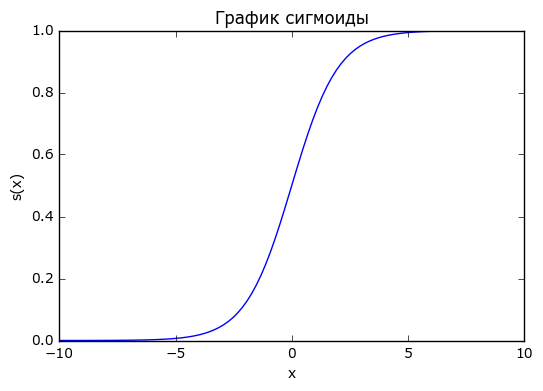

In [3]:
x = np.linspace(-10, 10, 100)
y = s(x)
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('s(x)')
plt.title('График сигмоиды')
plt.show()

В качестве функционала качества в логистической регрессии для улучшения сходимости лучше использовать не среднеквадратическую ошибку (MSE), а кросс-энтропию (cross-entropy, её ещё называют log-loss).

$$
J(\theta) = - \frac1{2m} \sum_{i=1}^m \Big[ 
    y^{(i)} \ln \sigma (\theta^T x^{(i)}) + (1 - y^{(i)}) \ln \big(1 - \sigma (\theta^T x^{(i)})\big)
\Big].
$$

Это выражение можно получить с помощью метода максимального правдоподобия, но его легко понять и интуитивно.

Рассмотрим случай одного прецедента. Если $y = 1$, «работает» только первое слагаемое под суммой. Оно тем больше (с учётом минуса перед суммой), чем ближе предсказанное значение (то есть значение функции $\sigma$) к 0. Если же оно равно 1, то слагаемое равно нулю. То есть, чем больше предсказанное значение отличается от $y$, тем больше всё выражение. Аналогичные рассуждения можно провести и для $y=0$.

Полезной особенностью такого функционала качества является то, что выражение для его градиента формально совпадает с выражением градента линейной регрессии с точностью до $h_{\theta}(x)$.
$$
\big[\operatorname{grad} J(\theta)\big]_j = \frac1m \sum_{i=1}^m \big(h_{\theta}(x^{(i)})-y^{(i)}\big)x_j^{(i)}.
$$

Или в векторном виде:
$$
\operatorname{grad} J(\theta) = \frac1m X^T (h_{\theta}(X) - y).
$$

Таким образом программу для линейной регрессии легко преобразовать в программу для классификации методом логистической регрессии просто заменив модель $h_{\theta}(x)$.

Для борьбы с переобученностью как и в случае линейной регрессии добавляют «штраф» за большие значения коэффициентов $\theta_j$ (кроме $\theta_0$) в виде регуляризационного слагаемого:
$$
J(\theta) = - \frac1{2m} \sum_{i=1}^m \Big[ 
    y^{(i)} \ln \sigma (\theta^T x^{(i)}) + (1 - y^{(i)}) \ln \big(1 - \sigma (\theta^T x^{(i)})\big)
\Big] + \frac{\lambda}{2m} \sum_{j=1}^n\theta_j^2;
$$
$$
\big[\operatorname{grad} J(\theta)\big]_j = \frac1m \sum_{i=1}^m \big(h_{\theta}(x^{(i)})-y^{(i)}\big)x_j^{(i)} + \frac{\lambda}{m} \sum_{j=1}^n\theta_j.
$$

Увеличение $\lambda$ уменьшает переобученность, но и снижает точность. При $\lambda = 0$ регуляризации нет вообще.

Если регуляризационное слагаемое имеет вид $\frac{\lambda}{2m} \sum_{j=1}^n\theta_j^2$, то этот метод называется регуляризацией по Тихонову, а если $\frac{\lambda}{2m} \sum_{j=1}^n\left|\theta_j\right|$ — методом LASSO.

Метод опорных векторов (SVM)
----------------------------

Формально метод опорных векторов очень похож на логистическую регрессию с тем отличием, что логарифмические слагаемые в функции потерь заменены кусочно-линейными аппроксимациями $R_1$ и $R_0$. Также регуляризационный коэффициент перенесён к первому слагаемому, что не влияет на результат, так как не смещает $\arg \min J(\theta)$.

В итоге получаем:
$$
J(\theta) = C \sum_{i=1}^m \Big[ 
    y^{(i)} R_1 (\theta^T x^{(i)}) + (1 - y^{(i)}) R_0 (\theta^T x^{(i)})
\Big] + \sum_{j=1}^n\theta_j^2.
$$

Геометрически идея SVM заключается в поиске такой разделяющей прямой, чтобы зазор между двумя классами был максимальным.

Метод k ближайших соседей (kNN)
-------------------------------

Для того, чтобы применять метод kNN необходимо ввести понятие расстояния между объектами. Для вычисления расстояния можно использовать произвольные метрики. Часто используют метрики L2 (эвклидово расстояние, норма $l_2$) и L1 (манхэттенское расстояние, норма $l_1$). Например, для метрики L2 расстояние вычисляется следующим образом:
$$
\left\|x^{(i)} - x^{(j)}\right\|_2 = \sqrt{ \sum_{k=0}^n \left( x^{(i)}_k - x^{(j)}_k \right) ^ 2 } = 
\sqrt{\left(x^{(i)} - x^{(j)}\right)^T\left(x^{(i)} - x^{(j)}\right)}.
$$

Идея метода в следующем. Для того, чтобы определить класс нового объекта, в обучающей выборке находят k ближайших к нему объектов — ближайшх соседей. Класс объекта принимается равным классу, к которому относится большинство ближайших соседей.

Метод плохо работает, если обучающая выборка очень большая, так как поиск может стать очень долгим. К преимуществам метода относится то, что он не требует никаких предварительных вычислений.

Библиотека scikit-learn
-----------------------



Популярная библиотека scikit-learn содержит реализации многих методов машинного обучения. В том числе логистической регрессии (`sklearn.linear_model.LogisticRegression`), классификации на основе SVM (`sklearn.svm.SVC`) и kNN (`sklearn.neighbors.KNeighborsClassifier`).

Работа с классификаторами в библиотеке единообразна и отличается лишь строкой, в которой создаётся конкретный классификатор. Рассмотрим работу с библиотекой на примере SVM.

Подключение библиотеки и извлечение классификатора SVC:

In [4]:
from sklearn.svm import SVC

В качестве исходных данных возмём случайно сгенерированные точки на плоскости, группирующиеся в два кластера.

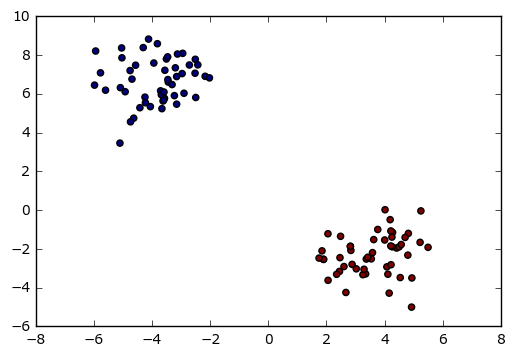

In [5]:
from sklearn.datasets.samples_generator import make_blobs

# Генерируем случайные данные
X, y = make_blobs(n_samples=100,  # число точек
                  centers=2,      # число кластеров
                  n_features=2)   # число признаков

plt.scatter(X[:, 0], X[:,1], c=y)
plt.show()

Создадим классификатор. Большую часть параметров можно не задавать, укажем только значение коэффициента регуляризации $C$ и тип классификатора — линейный (`linear`). Кроме линейного можно использовать, например, радиально-базисные функции (`rbf`) или многочлены (`poly`). Для многочленов нужно указывать степень (параметр `degree`).

In [6]:
clf = SVC(C=1.0,             # коэффициент регуляризации
          kernel='linear')   # вид ядра (линейное)

print(clf)                   # Вывод значения параметров

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


У всех классификаторов есть метод `fit`, выполняющий обучение. Пользоваться им очень легко:

In [7]:
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Теперь, чтобы воспользоваться уже обученным классификатором, вызовем метод `predict`. Он принимает на входе матрицу, строки которой содержат признаки объектов, и возвращает вектор с классами. Определим класс точки $(0, 1)$:

In [8]:
clf.predict(np.array([[0, 1]]))

array([1])

Проверить точность обучения можно с помощью метода `score`. Он возвращает долю правильно классифицированных объектов. Проверим точность классификатора на исходной выборке (хотя всегда проверяют на других данных):

In [9]:
clf.score(X, y)

1.0

Разбить исходную выборку случайным образом на две части — обучающую и тестовую — можно функцией `train_test_split` (впрочем, ниже мы рассмотрим более эффективный метод — перекрёстную проверку). Например:

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,             # Данные
    test_size=0.33    # Объём тестовой выборки (доля объектов)
    )

print(X_train.shape)
print(X_test.shape)

(67, 2)
(33, 2)


Если точность на обучающей выборке намного выше точности на тестовой, скорее всего имеет место переобученность модели.

Построим разделяющую кривую. Для этого вычислим значения классов на сетке с малым шагом $h$ и отобразим границу в виде линии. 

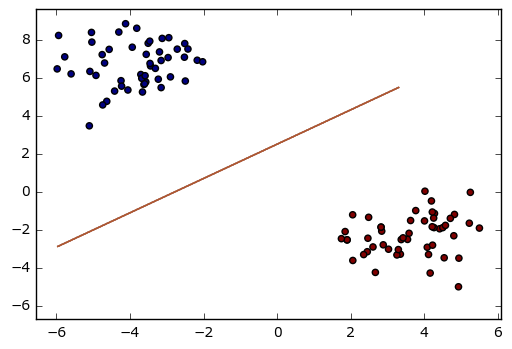

In [11]:
h = 0.01 # Шаг сетки

# Строим сетку
xx, yy = np.meshgrid(np.arange(min(X[:, 0]), max(X[:, 0]), h),
                     np.arange(min(X[:, 0]), max(X[:, 0]), h))


# Вычисляем класс для каждой точки сетки
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Отображаем данные и границу классов
plt.scatter(X[:, 0], X[:,1], c=y)
plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
plt.show()

Подготовка данных
-----------------



Значения разных признаков могут иметь сильно различающиеся масштабы. Это может существенно повлиять на точность обучения. Поэтому данные предварительно нормируют при помощи деления на характерную (среднюю) величину и смещения к нулю. Это можно делать автоматически средствами библиотеки.

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

scaler = StandardScaler().fit(X_train)            # scaler хранит параметры нормировки
X_train_transformed = scaler.transform(X_train)   # нормируем с теми же параметрами

clf = SVC().fit(X_train_transformed, y_train)     # создаём и обучаем классификатор

X_test_transformed = scaler.transform(X_test)     # нормируем тестовую выборку
clf.score(X_test_transformed, y_test)             # оцениваем результат

1.0

Перекрёстная проверка
---------------------

При оценке качества модели важно оставить часть данных для тестирования. Хотя тестовая выборка и выделяется обычно случайно, разбиение может оказаться неудачным и переобученность модели окажется незамеченной. Более эффективно применение перекрёстной проверки (crossvalidation).

При перекрёстной проверке данные разбиваются на несколько равных частей (пять — хороший выбор). Первая часть оставляется для тестирование, а на остальных модель обучается. Затем вторая оставляется для тестирования и так далее. В итоге получаем ошибки для каждого разбиения. Итоговую ошибку можно вычислить как среднее из них.

In [13]:
from sklearn.model_selection import cross_val_score
clf = SVC(kernel='linear', C=1)
scores = cross_val_score(clf,  # Классификатор
                         X, y, # Все данные
                         cv=5  # Количество частей
                        )
print (scores)

[ 1.  1.  1.  1.  1.]


Оценка доверительного интервала для доли верно распознаваемых объектов:

In [14]:
print ("Точность: %0.2f (±%0.2f)" % (scores.mean(), scores.std() * 2))

Точность: 1.00 (±0.00)


Ирисы Фишера
------------

Один из стандартных наборов данных для проверки алгоритмов классификации — ирисы Фишера. Он был подготовлен в 1936 году известным математиком и биологом Р. Фишером и содержит информацию о 150 экземплярах ирисов следующих видов:

- Ирис щетинистый (Iris setosa),
- Ирис виргинский (Iris virginica) и
- Ирис разноцветный (Iris versicolor).

Каждый вид представлен 50 экземплярами. Признаки, входящие в набор:

- длина наружной доли околоцветника (sepal length);
- ширина наружной доли околоцветника (sepal width);
- длина внутренней доли околоцветника (petal length);
- ширина внутренней доли околоцветника (petal width).

В библиотеке scikit-learn есть возможность автоматически загрузить этот набор данных:

In [15]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris['data']
y = iris['target']

Задание
-------

1. Попробуйте решить рассмотренную выше задачу для случая трёх и более классов. В этой и последующих задачах выполните нормализацию перед обучением и оцените результаты с помощью перекрёстной проверки. Посмотрите, как влияет параметр C на решение. Попробуйте использовать полиномиальный классификатор ('poly') или радиально-базисные функции ('rbf').
2. Решите задачу классификации ирисов Фишера с помошью логистической регрессии с использованием scikit-learn и непосредственным программированием. (Для этого может пригодиться код из предыдущей лабораторной работы.)
3. Решите задачу классификации ирисов Фишера методом kNN с использованием scikit-learn и непосредственным программированием. Как на результат влияет параметр k?
4. Решите задачу классификации ирисов Фишера методом SVM с использованием scikit-learn. Как на результат влияет параметр C?
5. Сформулируйте и запишите выводы. Как влияет регуляризация на результаты обучения? Можно ли обучить классификатор так, чтобы он не давал ошибок? Какой метод показал себя лучше: логистическая регрессия, метод опорных векторов или метод kNN?